## Why Conv?

设计适合于计算机视觉的神经网络架构。

1. *平移不变性*（translation invariance）：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。
1. *局部性*（locality）：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。

使用$[\mathbf{X}]_{i, j}$和$[\mathbf{H}]_{i, j}$分别表示输入图像和隐藏表示中位置（$i$,$j$）处的像素。
为了使每个隐藏神经元都能接收到每个输入像素的信息，我们将参数从权重矩阵（如同我们先前在多层感知机中所做的那样）替换为四阶权重张量$\mathsf{W}$。假设$\mathbf{U}$包含偏置参数，我们可以将全连接层形式化地表示为

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

其中，从$\mathsf{W}$到$\mathsf{V}$的转换只是形式上的转换，因为在这两个四阶张量的元素之间存在一一对应的关系。
我们只需重新索引下标$(k, l)$，使$k = i+a$、$l = j+b$，由此可得$[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$。
索引$a$和$b$通过在正偏移和负偏移之间移动覆盖了整个图像。
对于隐藏表示中任意给定位置（$i$,$j$）处的像素值$[\mathbf{H}]_{i, j}$，可以通过在$x$中以$(i, j)$为中心对像素进行加权求和得到，加权使用的权重为$[\mathsf{V}]_{i, j, a, b}$。


现在引用上述的第一个原则：平移不变性。
这意味着检测对象在输入$\mathbf{X}$中的平移，应该仅导致隐藏表示$\mathbf{H}$中的平移。也就是说，$\mathsf{V}$和$\mathbf{U}$实际上不依赖于$(i, j)$的值，即$[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$。并且$\mathbf{U}$是一个常数，比如$u$。因此，我们可以简化$\mathbf{H}$定义为：

$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}.$$

这就是*卷积*（convolution）。我们是在使用系数$[\mathbf{V}]_{a, b}$对位置$(i, j)$附近的像素$(i+a, j+b)$进行加权得到$[\mathbf{H}]_{i, j}$。
注意，$[\mathbf{V}]_{a, b}$的系数比$[\mathsf{V}]_{i, j, a, b}$少很多，因为前者不再依赖于图像中的位置。这就是显著的进步！

现在引用上述的第二个原则：局部性。如上所述，为了收集用来训练参数$[\mathbf{H}]_{i, j}$的相关信息，我们不应偏离到距$(i, j)$很远的地方。这意味着在$|a|> \Delta$或$|b| > \Delta$的范围之外，我们可以设置$[\mathbf{V}]_{a, b} = 0$。因此，我们可以将$[\mathbf{H}]_{i, j}$重写为

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$

简而言之， 上式是一个*卷积层*（convolutional layer），而卷积神经网络是包含卷积层的一类特殊的神经网络。
在深度学习研究社区中，$\mathbf{V}$被称为*卷积核*（convolution kernel）或者*滤波器*（filter），亦或简单地称之为该卷积层的*权重*，通常该权重是可学习的参数。
当图像处理的局部区域很小时，卷积神经网络与多层感知机的训练差异可能是巨大的：以前，多层感知机可能需要数十亿个参数来表示网络中的一层，而现在卷积神经网络通常只需要几百个参数，而且不需要改变输入或隐藏表示的维数。
参数大幅减少的代价是，我们的特征现在是平移不变的，并且当确定每个隐藏活性值时，每一层只包含局部的信息。
以上所有的权重学习都将依赖于归纳偏置。当这种偏置与现实相符时，我们就能得到样本有效的模型，并且这些模型能很好地泛化到未知数据中。
但如果这偏置与现实不符时，比如当图像不满足平移不变时，我们的模型可能难以拟合我们的训练数据。

## Conv Layer

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()

    return Y

In [3]:
# Test
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
corr2d(X, K)

tensor([[27., 37.],
        [57., 67.]])

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
K = torch.tensor([[1.0, -1.0]])

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [9]:
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 ==0:
        print(f'epoch {i+1}, loss {l.sum():.2f}')

epoch 2, loss 0.65
epoch 4, loss 0.11
epoch 6, loss 0.02
epoch 8, loss 0.00
epoch 10, loss 0.00


In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9973, -0.9943]])

In [11]:
X = torch.ones((8, 8))

In [12]:
X[0, 0], X[0, 1] = 0, 0
for i in range(1, X.shape[0] - 1):
    X[i, i] = 0
    X[i, i - 1] = 0
    X[i, i + 1] = 0

print(X)

tensor([[0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])


In [13]:
corr2d(X, K)

tensor([[ 0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [14]:
corr2d(X.T, K)

tensor([[ 0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -1.]])

In [15]:
corr2d(X, K.T)

tensor([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0., -1., -1., -1.]])

## Padding & Stride

通常，当垂直步幅为$s_h$、水平步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

In [16]:
import torch
from torch import nn

def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个通道：批量大小和通道
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [17]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [18]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1), stride=2)   
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [19]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## Channels

In [20]:
import torch
from d2l import torch as d2l

In [21]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [22]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [23]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [24]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [25]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [26]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [27]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [28]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
float(torch.abs(Y1 - Y2).sum()) < 1e-6

True

## Pooling

In [29]:
import torch
from torch import nn
from d2l import torch as d2l

In [30]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [31]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [32]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [33]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，**深度学习框架中的步幅与汇聚窗口的大小相同**。
因此，如果我们使用形状为`(3, 3)`的汇聚窗口，那么默认情况下，我们得到的步幅形状为`(3, 3)`。


In [34]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [35]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [36]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [38]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [39]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## LeNet

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),  # 6 * 28 * 28
    nn.AvgPool2d(kernel_size=2, stride=2),  # 6 * 14 * 14
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),  # 16 * 10 * 10
    nn.AvgPool2d(kernel_size=2, stride=2),  # 16 * 5 * 5
    nn.Flatten(),  # 400
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),  # 120
    nn.Linear(120, 84), nn.Sigmoid(),  # 84
    nn.Linear(84, 10))  # 10

In [4]:
# Test
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [6]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train_loss', 'train_acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} exmaples/sec, on {str(device)}')

loss 0.471, train acc 0.822, test acc0.816
36636.2 exmaples/sec, on cuda:0


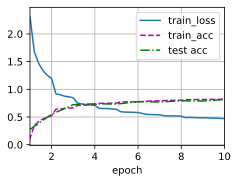

In [10]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### MaxPool2d

In [11]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),  # 6 * 28 * 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # 6 * 14 * 14
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),  # 16 * 10 * 10
    nn.MaxPool2d(kernel_size=2, stride=2),  # 16 * 5 * 5
    nn.Flatten(),  # 400
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),  # 120
    nn.Linear(120, 84), nn.Sigmoid(),  # 84
    nn.Linear(84, 10))  # 10

loss 0.413, train acc 0.846, test acc0.844
34936.1 exmaples/sec, on cuda:0


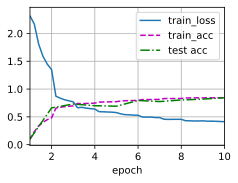

In [12]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### ReLU

In [29]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),  # 6 * 28 * 28
    nn.MaxPool2d(kernel_size=2, stride=2),  # 6 * 14 * 14
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),  # 16 * 10 * 10
    nn.MaxPool2d(kernel_size=2, stride=2),  # 16 * 5 * 5
    nn.Flatten(),  # 400
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),  # 120
    nn.Linear(120, 84), nn.ReLU(),  # 84
    nn.Linear(84, 10))  # 10

loss 0.353, train acc 0.863, test acc 0.843
32187.4 exmaples/sec, on cuda:0


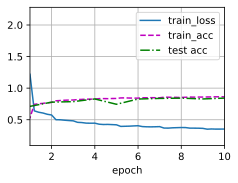

In [15]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.264, train acc 0.901, test acc 0.867
36165.6 exmaples/sec, on cuda:0


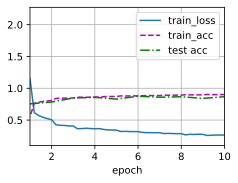

In [17]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**补充**

上网查询资料后得出loss不变`(ln 10 = 2.303, acc = 0.1, 已是随机猜测)`可能的几种情况：

- 数据本身的问题 sigmoid能够成功说明数据本身没有问题，有问题可以进行批量规范化处理。

- 初始化权重的问题 初始化权重使用了Xavier初始化方法，应该没有问题

- 学习率过大的问题 推测可能是学习率过大导致loss在第一轮训练时就已经收敛到一个较小的值，由于学习率过大，后面的学习基本上是反复跳变不再收敛。

把学习率降低为为0.01后问题应该能解决

### Test on MNIST

In [21]:
import torchvision
from torch.utils import data
from torchvision import transforms

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)
train_iter2 = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=d2l.get_dataloader_workers())
test_iter2 = data.DataLoader(mnist_test, batch_size, shuffle=True,
                            num_workers=d2l.get_dataloader_workers())

lr, num_epochs = 0.4, 5  # 大约 6 轮往后直接就爆炸

loss 0.036, train acc 0.988, test acc 0.981
39445.1 exmaples/sec, on cuda:0


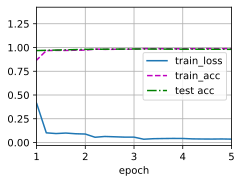

In [30]:
train_ch6(net, train_iter2, test_iter2, num_epochs, lr, d2l.try_gpu())

### The activation value on the first layer and second layer of LeNet

------------------------------------------------------------------------------


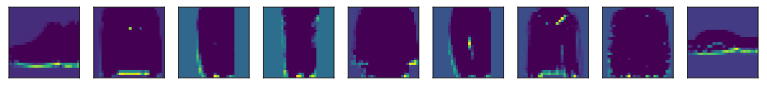

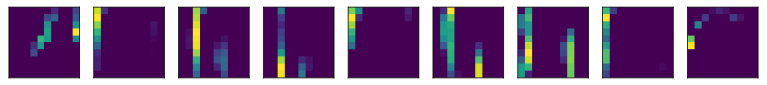

------------------------------------------------------------------------------


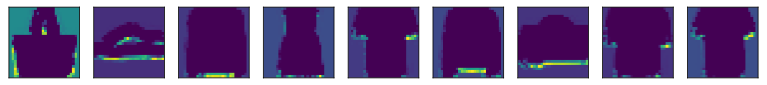

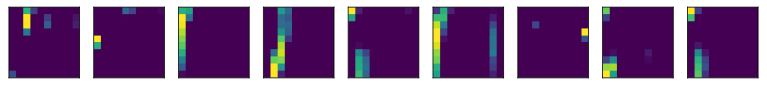

------------------------------------------------------------------------------


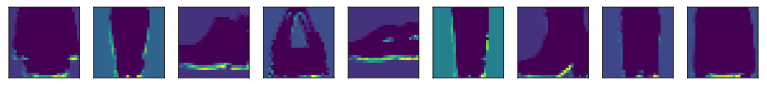

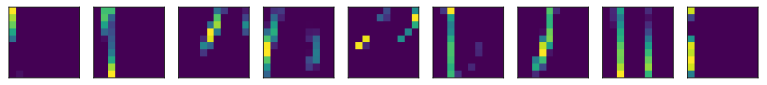

------------------------------------------------------------------------------


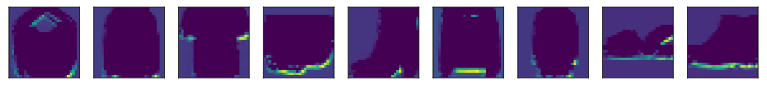

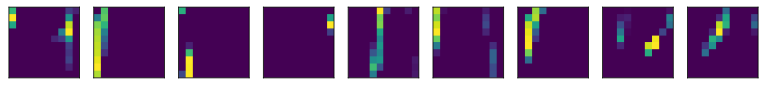

------------------------------------------------------------------------------


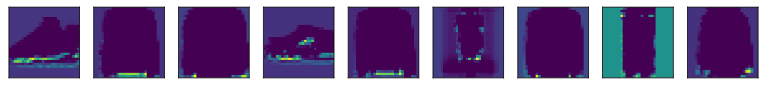

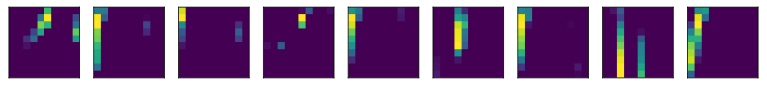

------------------------------------------------------------------------------


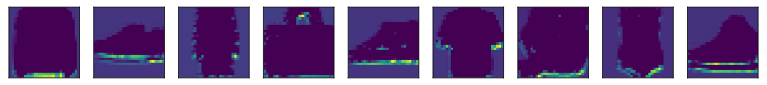

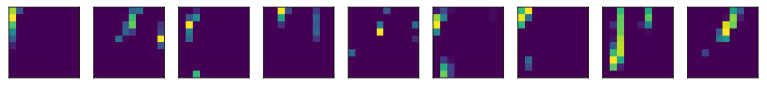

------------------------------------------------------------------------------


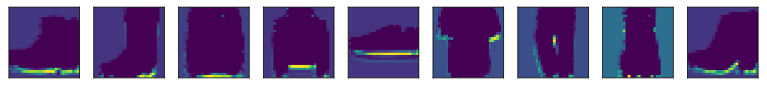

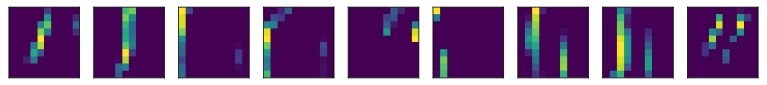

------------------------------------------------------------------------------


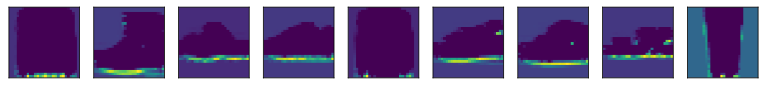

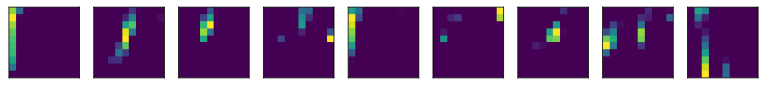

------------------------------------------------------------------------------


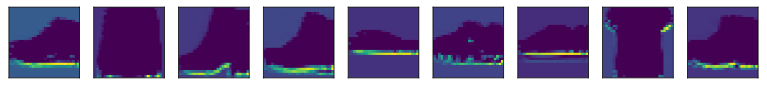

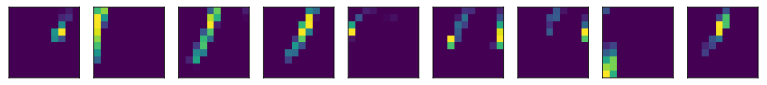

------------------------------------------------------------------------------


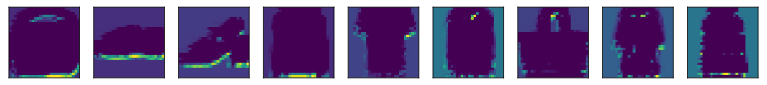

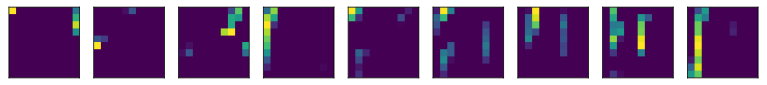

------------------------------------------------------------------------------


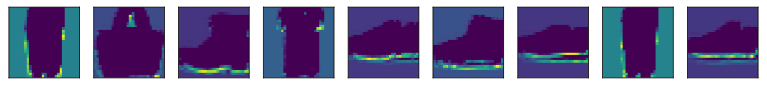

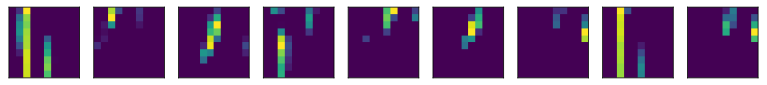

------------------------------------------------------------------------------


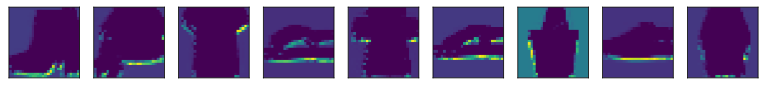

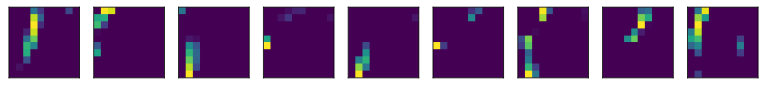

------------------------------------------------------------------------------


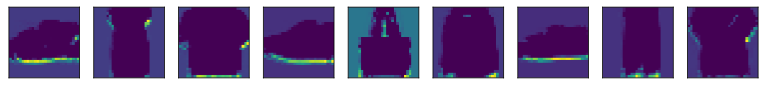

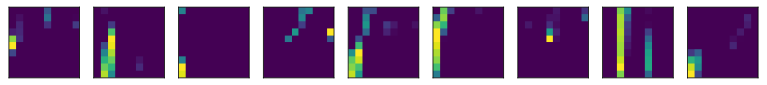

------------------------------------------------------------------------------


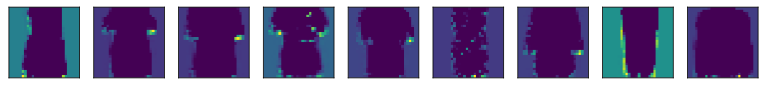

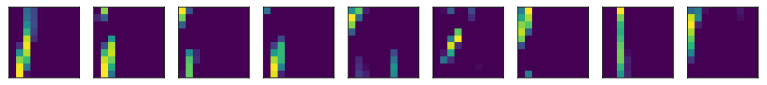

------------------------------------------------------------------------------


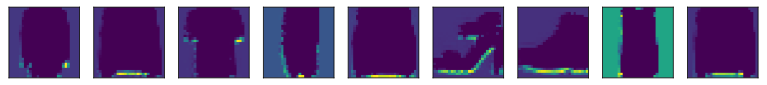

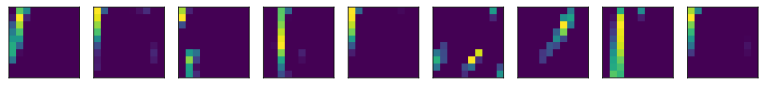

------------------------------------------------------------------------------


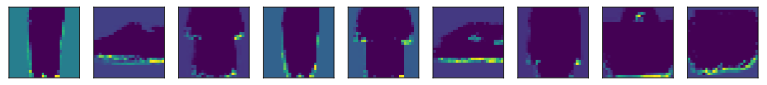

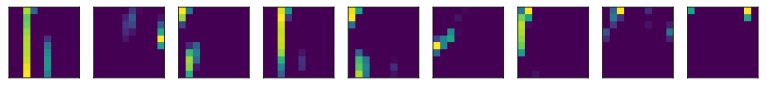

------------------------------------------------------------------------------


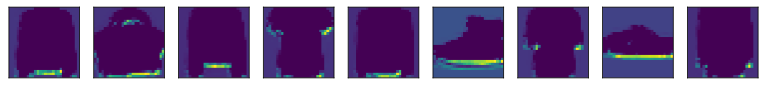

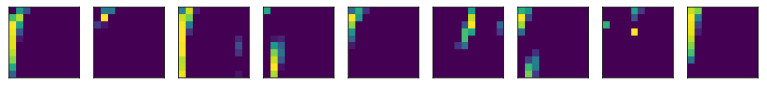

------------------------------------------------------------------------------


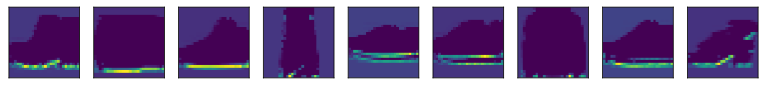

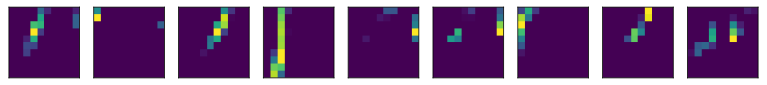

------------------------------------------------------------------------------


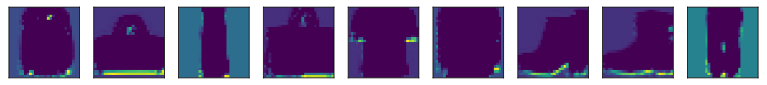

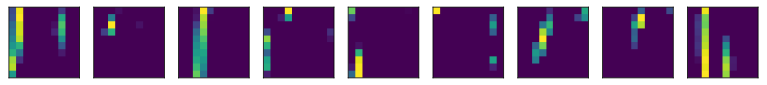

------------------------------------------------------------------------------


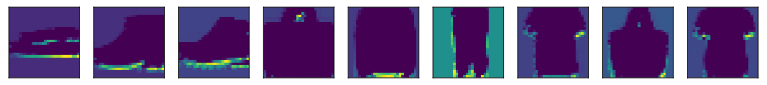

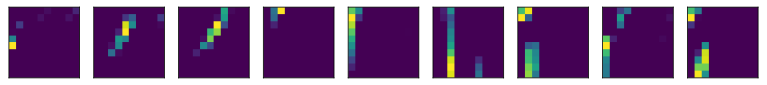

------------------------------------------------------------------------------


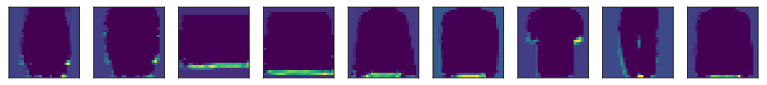

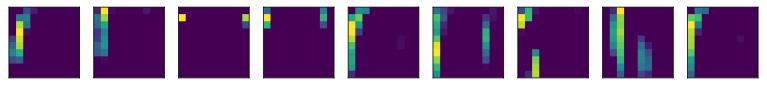

------------------------------------------------------------------------------


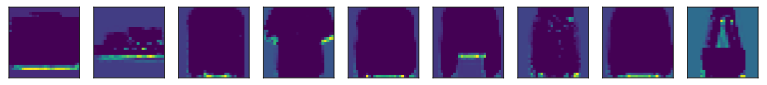

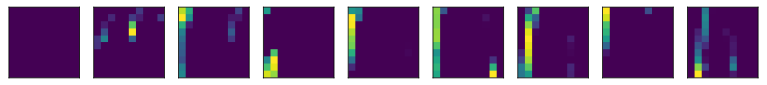

------------------------------------------------------------------------------


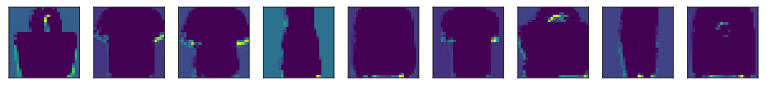

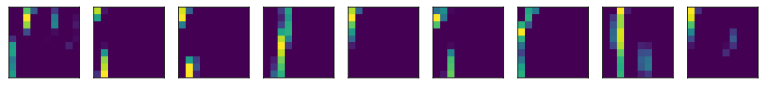

------------------------------------------------------------------------------


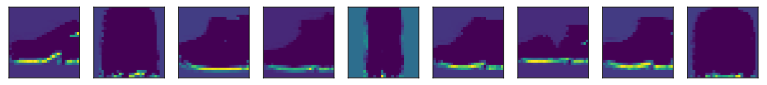

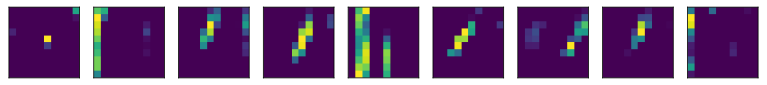

------------------------------------------------------------------------------


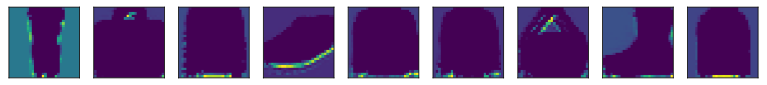

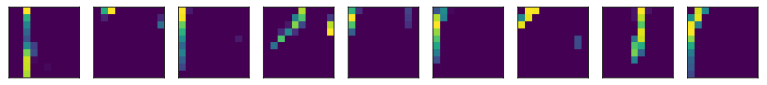

------------------------------------------------------------------------------


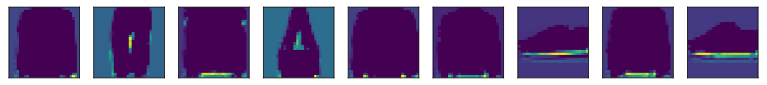

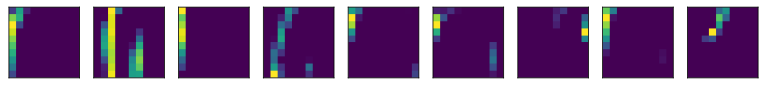

------------------------------------------------------------------------------


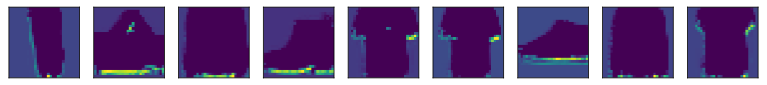

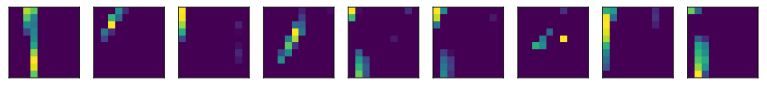

------------------------------------------------------------------------------


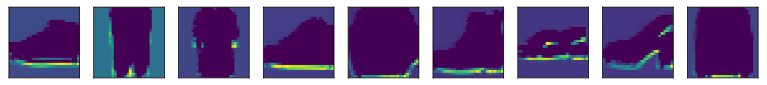

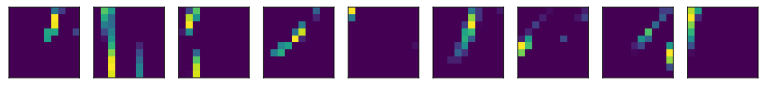

------------------------------------------------------------------------------


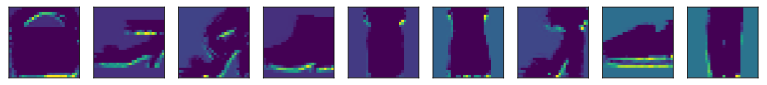

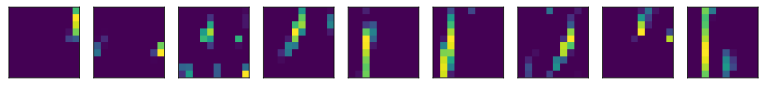

------------------------------------------------------------------------------


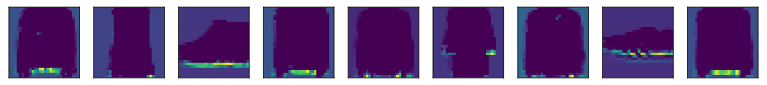

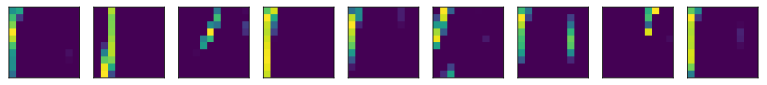

------------------------------------------------------------------------------


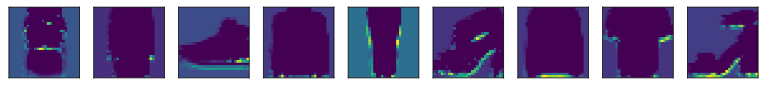

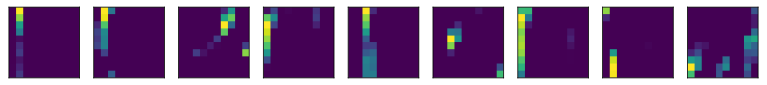

------------------------------------------------------------------------------


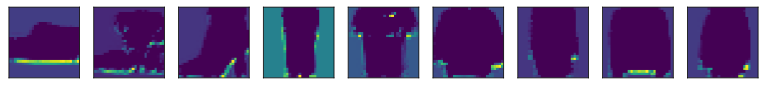

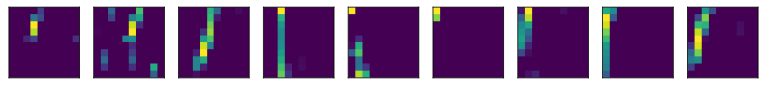

------------------------------------------------------------------------------


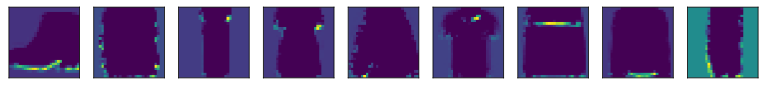

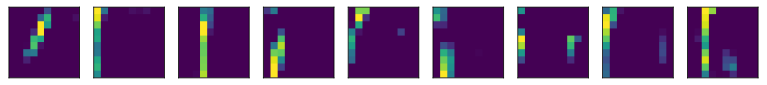

------------------------------------------------------------------------------


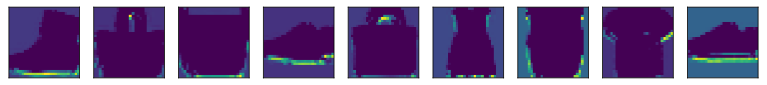

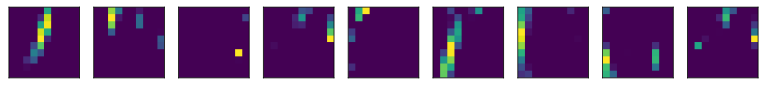

------------------------------------------------------------------------------


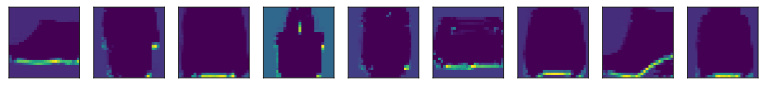

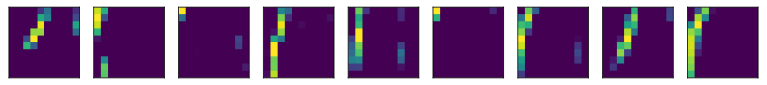

------------------------------------------------------------------------------


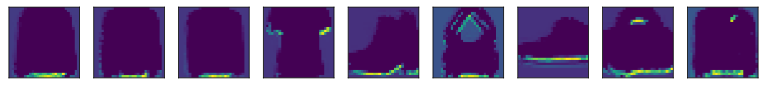

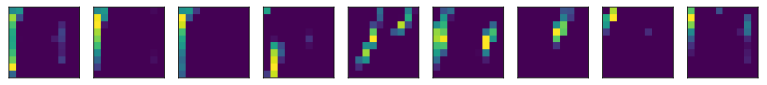

------------------------------------------------------------------------------


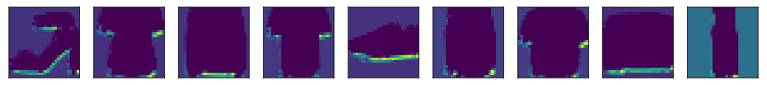

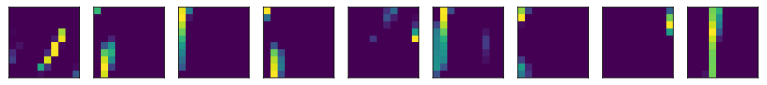

------------------------------------------------------------------------------


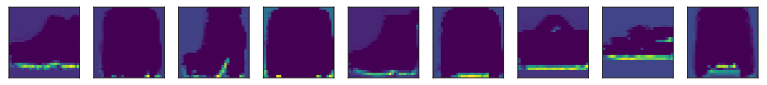

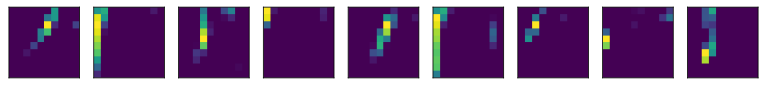

------------------------------------------------------------------------------


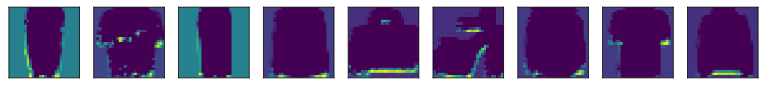

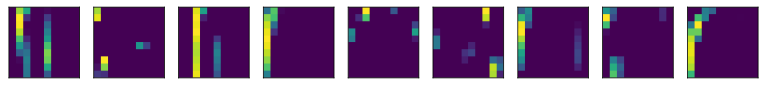

------------------------------------------------------------------------------


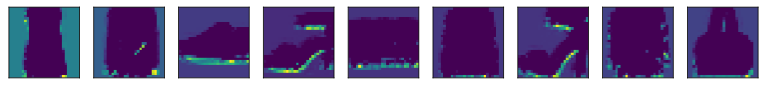

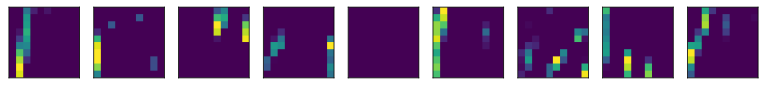

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 确保你的模型在正确的设备上
net = net.to(device)

for X, y in test_iter:
    # 将输入数据移动到与模型相同的设备上
    X = X.to(device)
    
    # 处理第一层 Sigmoid 层的输出
    x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]
    d2l.show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach(), 1, 9)
    
    print("------------------------------------------------------------------------------")

    # 处理第二层 Sigmoid 层的输出
    x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :]
    d2l.show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).cpu().detach(), 1, 9)
    
    d2l.plt.show()